In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

class TOPSIS_Solver:
    def __init__(self, data: pd.DataFrame):
        """data: 必须是清洗后的纯数值 DataFrame，索引为评价对象"""
        self.raw_data = data.copy()
        self.processed_data = data.copy()
        self.weights = None
        self.results = None

    def preprocess(self, direction_dict: dict, ideal_vals: dict = None):
        """
        direction_dict: {'列名': 'max'/'min'/'mid'}
        ideal_vals: {'列名': 18} (仅当类型为 mid 时需要)
        """
        df = self.processed_data
        for col, direction in direction_dict.items():
            x = df[col].values
            if direction == 'min': # 极小值 -> 极大值
                df[col] = x.max() - x
            elif direction == 'mid': # 中间值 -> 极大值
                if ideal_vals is None or col not in ideal_vals:
                    raise ValueError(f"中间型指标 {col} 必须提供理想值")
                target = ideal_vals[col]
                M = np.max(np.abs(x - target))
                # 防除零处理
                df[col] = 1 - np.abs(x - target) / (M + 1e-6)
        
        # 归一化 (Vector Normalization)
        self.norm_data = df / np.sqrt((df**2).sum())
        # 平移防止熵权法 ln(0) 报错 (使用 Min-Max 辅助计算熵权)
        self.shift_data = (df - df.min()) / (df.max() - df.min()) + 0.001

    def run(self, manual_weights: dict = None):
        """运行计算"""
        # 1. 确定权重 (优先使用人工权重，否则熵权)
        if manual_weights:
            w_series = pd.Series(manual_weights)
            self.weights = w_series / w_series.sum()
        elif self.weights is None:
            # 熵权法计算
            P = self.shift_data.div(self.shift_data.sum(axis=0), axis=1)
            E = -1/np.log(len(P)) * (P * np.log(P)).sum(axis=0)
            d = 1 - E
            self.weights = d / d.sum()
        
        # 2. 计算距离 (TOPSIS 核心)
        Z = self.norm_data * self.weights
        D_plus = np.sqrt(((Z - Z.max())**2).sum(axis=1))
        D_minus = np.sqrt(((Z - Z.min())**2).sum(axis=1))
        
        # 3. 计算得分
        Score = D_minus / (D_plus + D_minus)
        
        # 4. 整合结果
        self.results = self.raw_data.copy()
        self.results['Score'] = Score
        self.results['Rank'] = Score.rank(ascending=False)
        return self.results.sort_values('Rank')

    def plot_sensitivity(self, target_col, change_range=0.2):
        """自动画灵敏度分析图"""
        if self.weights is None: raise ValueError("请先运行 run()")
        base_w = self.weights.copy()
        col_idx = self.raw_data.columns.get_loc(target_col)
        rates = np.linspace(1-change_range, 1+change_range, 20)
        rankings = []
        for r in rates:
            temp_w = base_w.values.copy()
            temp_w[col_idx] *= r 
            temp_w = temp_w / temp_w.sum() # 重新归一化
            # 快速重算
            Z = self.norm_data * temp_w
            Dp = np.sqrt(((Z - Z.max())**2).sum(axis=1))
            Dm = np.sqrt(((Z - Z.min())**2).sum(axis=1))
            S = Dm / (Dp + Dm)
            rankings.append(S.rank(ascending=False).values)
            
        plt.figure(figsize=(8, 5))
        plt.plot(rates, rankings)
        plt.xlabel(f'{target_col} Weight Change Rate')
        plt.ylabel('Rank (Lower is Better)')
        plt.title(f'Sensitivity Analysis: {target_col}')
        plt.gca().invert_yaxis()
        plt.legend(self.raw_data.index, bbox_to_anchor=(1.05, 1))
        plt.grid(True, alpha=0.3)
        plt.show()

In [4]:
import pandas as pd
import numpy as np

# --- 🎯 演习目标：2026 美赛C题 模拟数据 (新能源工厂选址) ---
data = {
    'Site_ID': ['Site_A', 'Site_B', 'Site_C', 'Site_D', 'Site_E', 'Site_F'],
    'Land_Cost': [5000, 8500, 4200, 12000, 3000, 6000],        # 地价 (极小, Cost)
    'Labor_Pool': [50000, 80000, 45000, 150000, 20000, 55000], # 劳动力人口 (极大, Benefit)
    'Hwy_Dist': [4.5, 5.2, 8.0, 2.0, 100.0, 5.0],              # 距离高速 (中间型 Mid, 理想=5) -> Site_E 是坑
    'Quake_Risk': ['Medium', 'Low', 'Low', 'High', 'Low', 'Medium'], # 地震风险 (文本 Text) -> 需要清洗
    'Gov_Subsidy': [20, 50, 20, 80, np.nan, 30]                # 政府补贴 (极大 Benefit) -> Site_E 有空值
}

df_raw = pd.DataFrame(data)
df_raw.set_index('Site_ID', inplace=True)

# 导出模拟文件
df_raw.to_excel("00_Raw.xlsx")
print("✅ 演习数据 '00_Raw.xlsx' 生成完毕。")
print("📊 你的任务：指挥 AI 处理 Quake_Risk(文本), 填补 Gov_Subsidy(空值), 并完成评价。")
print("📋 复制下列列名备用:", df_raw.columns.tolist())

✅ 演习数据 '00_Raw.xlsx' 生成完毕。
📊 你的任务：指挥 AI 处理 Quake_Risk(文本), 填补 Gov_Subsidy(空值), 并完成评价。
📋 复制下列列名备用: ['Land_Cost', 'Labor_Pool', 'Hwy_Dist', 'Quake_Risk', 'Gov_Subsidy']


In [5]:
import pandas as pd
import numpy as np

# 1. 读取数据
# 设定 index_col 确保 Site_ID 被正确作为索引处理
input_file = "00_Raw.xlsx"
try:
    df = pd.read_excel(input_file, index_col='Site_ID')
    print(f"成功读取文件: {input_file}, 原始形状: {df.shape}")
except FileNotFoundError:
    print(f"错误: 找不到文件 {input_file}，请检查路径。")

# 2. 处理 'Quake_Risk' (文本映射)
# 这是一个定序变量 (Ordinal Variable)，映射为数值以便计算
risk_mapping = {'Low': 3, 'Medium': 2, 'High': 1}
df['Quake_Risk'] = df['Quake_Risk'].map(risk_mapping)

# 检查映射是否产生了新的 NaN (防止原始数据中有拼写错误，如 'low' vs 'Low')
if df['Quake_Risk'].isnull().any():
    print("警告: 'Quake_Risk' 列存在无法映射的值，已转换为 NaN。")

# 3. 处理 'Gov_Subsidy' (均值填充)
# 计算均值并填充空值
subsidy_mean = df['Gov_Subsidy'].mean()
df['Gov_Subsidy'] = df['Gov_Subsidy'].fillna(subsidy_mean)

# 4. 打印清洗后的前 5 行
print("\n--- 清洗后数据前 5 行 ---")
print(df.head())

# 5. 保存数据
output_file = "01_Clean.xlsx"
df.to_excel(output_file)
print(f"\n已保存清洗后的数据至: {output_file}")

成功读取文件: 00_Raw.xlsx, 原始形状: (6, 5)

--- 清洗后数据前 5 行 ---
         Land_Cost  Labor_Pool  Hwy_Dist  Quake_Risk  Gov_Subsidy
Site_ID                                                          
Site_A        5000       50000       4.5           2         20.0
Site_B        8500       80000       5.2           3         50.0
Site_C        4200       45000       8.0           3         20.0
Site_D       12000      150000       2.0           1         80.0
Site_E        3000       20000     100.0           3         40.0

已保存清洗后的数据至: 01_Clean.xlsx


In [6]:
import pandas as pd

# 1. 读取清洗后的数据
# 假设 Site_ID 依然作为索引列
df = pd.read_excel("01_Clean.xlsx", index_col='Site_ID')

# 2. 实例化模型
# 注意：这里假设您的类定义已经在内存中生效
model = TOPSIS_Solver(df)

# 3. 定义指标方向 (Direction Dictionary)
# Land_Cost -> 成本型 (越低越好 -> 'min')
# Labor_Pool, Gov_Subsidy -> 效益型 (越高越好 -> 'max')
# Quake_Risk -> 效益型 (之前已映射为分数: 3分=低风险，故分数越高越好 -> 'max')
# Hwy_Dist -> 中间型 (指定值最好 -> 'mid')
direction_dict = {
    'Land_Cost': 'min',
    'Labor_Pool': 'max',
    'Gov_Subsidy': 'max',
    'Quake_Risk': 'max',
    'Hwy_Dist': 'mid'
}

# 4. 定义中间型指标的最佳值 (Ideal Values)
# 仅需指定 type='mid' 的列
ideal_vals = {
    'Hwy_Dist': 5
}

# 5. 调用预处理方法
# 将方向和最佳值传入接口
model.preprocess(direction_dict=direction_dict, ideal_vals=ideal_vals)

# 6. 检查归一化后的数据
print("--- 正向化与归一化后的数据前 5 行 (model.norm_data) ---")
print(model.norm_data.head())

--- 正向化与归一化后的数据前 5 行 (model.norm_data) ---
         Land_Cost  Labor_Pool      Hwy_Dist  Quake_Risk  Gov_Subsidy
Site_ID                                                              
Site_A    0.452707    0.260466  4.511766e-01    0.333333     0.181071
Site_B    0.226354    0.416746  4.526089e-01    0.500000     0.452679
Site_C    0.504445    0.234420  4.392407e-01    0.500000     0.181071
Site_D    0.000000    0.781398  4.392407e-01    0.166667     0.724286
Site_E    0.582052    0.104186  4.774355e-09    0.500000     0.362143


--- 自动计算的熵权 (Entropy Weights) ---
Land_Cost      0.138720
Labor_Pool     0.240694
Hwy_Dist       0.112704
Quake_Risk     0.143425
Gov_Subsidy    0.364457
dtype: float64

计算结果已保存至: 03_Result.xlsx

--- 排名靠前方案 (Top 5) ---
         Land_Cost  Labor_Pool  Hwy_Dist  Quake_Risk  Gov_Subsidy     Score  \
Site_ID                                                                       
Site_D       12000      150000       2.0           1           80  0.735660   
Site_B        8500       80000       5.2           3           50  0.508454   
Site_E        3000       20000     100.0           3           40  0.347003   
Site_F        6000       55000       5.0           2           30  0.315790   
Site_C        4200       45000       8.0           3           20  0.302113   

         Rank  
Site_ID        
Site_D    1.0  
Site_B    2.0  
Site_E    3.0  
Site_F    4.0  
Site_C    5.0  

正在生成 'Hwy_Dist' 的灵敏度分析图...


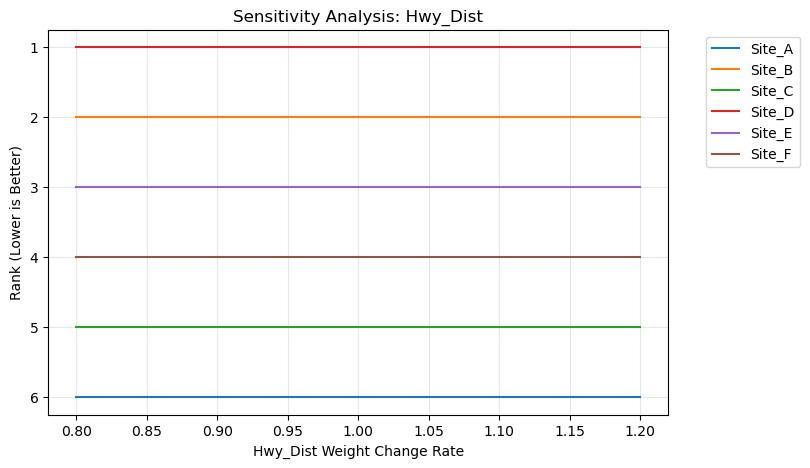

In [7]:
# 1. 默认运行 (熵权法)
# run() 内部会自动计算熵权并进行 TOPSIS 排序
result_df = model.run()

# 打印自动计算出的权重 (假设类属性名为 weights，如不同请查阅您的类定义)
print("--- 自动计算的熵权 (Entropy Weights) ---")
if hasattr(model, 'weights'):
    print(model.weights)
else:
    print("模型运行完成 (未找到 .weights 属性，请检查类定义以获取具体权重值)")

# 2. 【手动权重模板】
# ------------------------------------------------------------------
# 如果您希望覆盖熵权，请取消下方注释，修改数值(和为1)，并重新运行 .run()
# manual_weights = {
#     'Land_Cost': 0.2,   # 成本型
#     'Labor_Pool': 0.2,  # 效益型
#     'Hwy_Dist': 0.2,    # 中间型
#     'Quake_Risk': 0.2,  # 效益型
#     'Gov_Subsidy': 0.2  # 效益型
# }
# result_df = model.run(manual_weights=manual_weights)
# ------------------------------------------------------------------

# 3. 保存结果
output_file = "03_Result.xlsx"
result_df.to_excel(output_file)
print(f"\n计算结果已保存至: {output_file}")
print("\n--- 排名靠前方案 (Top 5) ---")
print(result_df.head())

# 4. 灵敏度分析绘图
# 针对 'Hwy_Dist' (高速公路距离) 进行分析，观察其权重变化对排名的影响
print(f"\n正在生成 'Hwy_Dist' 的灵敏度分析图...")
model.plot_sensitivity('Hwy_Dist')